# Adding and Rotating Molecules in Crystals

This notebook demonstrates how to use the `add_structure_position` and `rotate_structure` functions to add a molecule at a certain position and rotates it around a certain point. Additionally, a whole sub structure will be rotated around a given vector.


## Loading Framework and Molecule

To begin, we load the **perovskite framework** and the **molecule** from `.xyz` files using the `Structure` class from `aim2dat`.  

- Load the **framework** "PBI3" from `PBI3.xyz` via `from_file` with the `Structure` class.
- Load the **molecule** "CN2H5" from `CN2H5.xyz` via `from_file` with the `Structure` class.


In [1]:
from aim2dat.strct import Structure

framework = Structure.from_file("files/strc/PBI3.xyz")
molecule = Structure.from_file("files/strc/CN2H5.xyz")

## Example 1: Adding a Molecule into the Framework

In this example, we **insert a molecule** into the structure at a specified position. The molecule is placed in the framework while preserving its structure. The coordinates provided for the insertion correspond to the center of the framework.


In [2]:
from aim2dat.strct.ext_manipulation import add_structure_position

position = [3.176188, 3.244215, 3.25149] # Chosen center of the framework (in Å)
structure = add_structure_position(framework, position, molecule)

Below is a visualization of the framework with the newly added molecule. We apply a **45-degree rotation** for better clarity.


<Axes: >

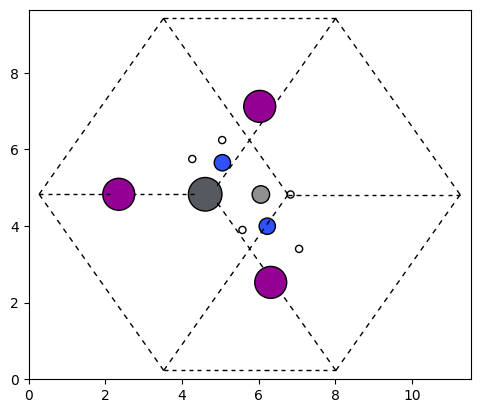

In [3]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

fig, ax = plt.subplots()
plot_atoms(structure.to_ase_atoms(), ax, radii=0.3, rotation=('45x,45y,0z'))

## Example 2: Rotate a Molecule in a structure

In this case, we demonstrate to rotate the new added molecule around its center **by 90 degrees along the x-axis**. The default rotation center is located at the midpoint of the atomic positions within the chosen molecule but can be modified. We need to specify the indices of the atoms we want to rotate.

In [4]:
from aim2dat.strct.ext_manipulation import rotate_structure

# Define rotation parameters
selected_atoms = [4, 5, 6, 7, 8, 9, 10, 11]  # Indices of the molecule to rotate
rotation_angles = [90, 0, 0]  # Rotation of 90 degrees around the x-axis

# Apply rotation
rot_struct = rotate_structure(
    structure,
    site_indices=selected_atoms,
    angles=rotation_angles
)
rot_strct = rotate_structure(
    structure,
    angles = [90,0,0],
    site_indices = [4, 5, 6, 7, 8, 9, 10, 11],
)

This molecule is now rotated in the framework shown down below:

<Axes: >

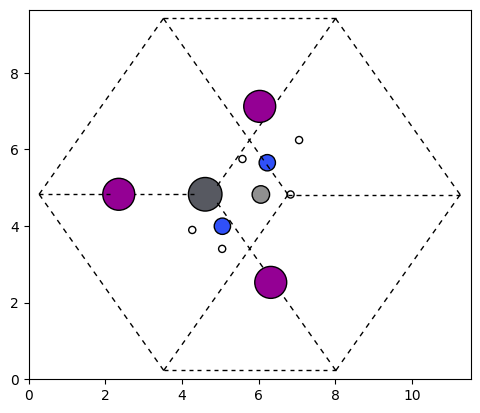

In [5]:
fig, ax = plt.subplots()
plot_atoms(rot_struct.to_ase_atoms(), ax, radii=0.3, rotation=('45x,45y,0z'))

## Example 3: Rotating a Substructure in a Crystal

In this case, we demonstrate how to **rotate each linker molecule** in the MOF-5 structure **by 90 degrees**. 

For better visualization, we use the **conventional unit cell** of the MOF-5 structure, allowing us to observe the changes clearly.


In [6]:
MOF5 = Structure.from_file("files/strc/Zn_MOF5_H_conv.xyz")

Now we can identify the linkers by setting "Zn" as the start and endpoint while excluding non-linker elements, "Zn" and "O".

In [7]:
from aim2dat.strct.ext_analysis import calc_molecular_fragments

fragments = calc_molecular_fragments(
    MOF5,
    exclude_elements=["Zn", "O"],
    end_point_elements = "Zn",  
    method="atomic_radius",
    radius_type="chen_manz",
)

With this information, we identify each connection pair and determine their connecting vector.

In [8]:
import numpy as np

pairs = []
rotation_vectors = []

# Find the furthest connected atoms in each fragment
for frag in fragments:
    max_dist = 0
    furthest_pair = None
    furthest_vec = None

    # Iterate over all atom pairs in the fragment
    for idx1, pos1 in zip(frag["site_attributes"]["parent_indices"], frag["positions"]):
        for idx2, pos2 in zip(frag["site_attributes"]["parent_indices"], frag["positions"]):
            if idx1 >= idx2:
                continue
            
            # Compute distance between two atoms
            dist = np.linalg.norm(np.array(pos1) - np.array(pos2))
            if dist > max_dist:
                max_dist = dist
                furthest_pair = (idx1, idx2)
                furthest_vec = np.array(pos2) - np.array(pos1)
                
    # Store the furthest atom pair and the rotation vector
    if furthest_pair:
        pairs.append(furthest_pair)
        rotation_vectors.append(furthest_vec)


Now we can iterate through all fragments and rotate them by 90 degrees. For this, we copy the original structure, so it will not be manipulated. In this case, we do not change the label, since each iteration would change each time.

In [9]:
from aim2dat.strct.ext_manipulation import rotate_structure

# Make a copy of the structure before applying rotations
rot_struct = MOF5.copy()

# Apply rotation to each linker fragment
for pair, frag, rot_vec in zip(pairs, fragments, rotation_vectors):
    rot_struct = rotate_structure(
        rot_struct,
        site_indices=frag["site_attributes"]["parent_indices"],
        angles=90,  # Degrees
        vector=rot_vec,  # Normalized rotation vector
        origin=MOF5.get_positions()[pair[0]],  # Use one of the connected atoms as origin
        change_label=False,
        wrap=True  # Ensures atoms remain in unit cell
    )

Now we can compare before and after the rotation.

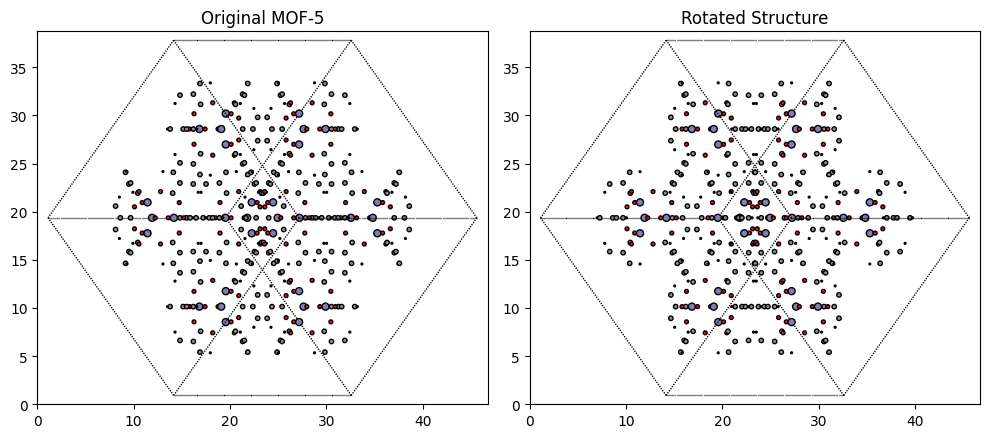

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

plot_atoms(MOF5.to_ase_atoms(), ax[0], radii=0.3, rotation=('45x,45y,0z'))
ax[0].set_title("Original MOF-5", fontsize=12)

plot_atoms(rot_struct.to_ase_atoms(), ax[1], radii=0.3, rotation=('45x,45y,0z'))
ax[1].set_title("Rotated Structure", fontsize=12)

plt.tight_layout()
plt.show()

## Example 4: Adding an oxygen cluster randomly on Graphene

In this example, we **insert an oxygen atom** on top of a **graphene structure**. At first, we need to load the **structures** from the file.

In [11]:
Graphene = Structure.from_file("files/strc/4x4-SC_graphene.in")
oxygen = Structure.from_file("files/strc/O.xyz")

We will use the function `add_structure_random` and with the keyword `dist_threshold` we can set the distances. In this example the oxygen should have a **minimum length** of 0.8~A and a **maximum length** of 2~A from the **structure**.

<Axes: >

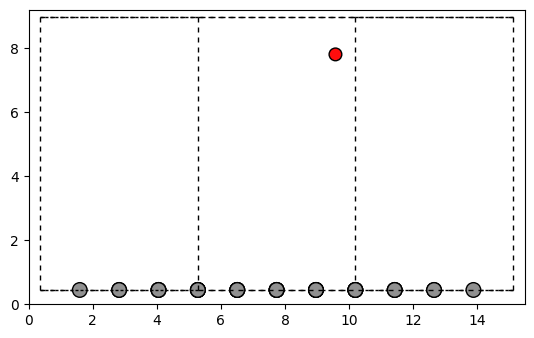

In [12]:
from aim2dat.strct.ext_manipulation import add_structure_random

Grapheneoxyde = add_structure_random(
    structure=Graphene,
    guest_structure=oxygen,
    dist_threshold=[.8,2]
)

fig, ax = plt.subplots()
plot_atoms(Grapheneoxyde.to_ase_atoms(), ax, radii=0.3, rotation=('-90x,0y,0z'))

Next, we would like to have an **oxygen close to the other oxygen to build a cluster**. Thus, we define a `dict` with different distances for the oxygen and the carbon in `dist_threshold` and use our output structure from above as input.

<Axes: >

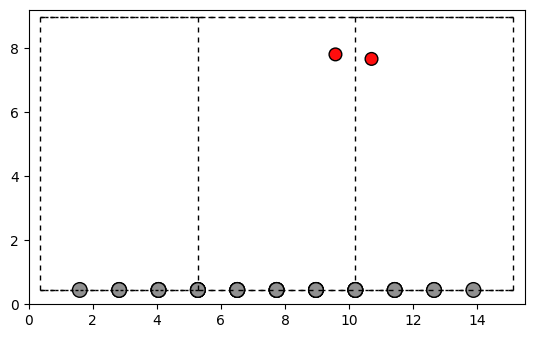

In [ ]:
Graphenedioxyde = add_structure_random(
    structure=Grapheneoxyde,
    guest_structure=oxygen,
    dist_threshold={("C", "O"): [.8,2], ("O", "O"): [1,1.5]}
)

fig, ax = plt.subplots()
plot_atoms(Graphenedioxyde.to_ase_atoms(), ax, radii=0.3, rotation=('-90x,0y,0z'))

To make life a little simpler, we can use the `StructureOperations` class. To import a **structure** into the class, we need to add a `label` to the **structure** first and then we can perform the same operation `add_structure_random` 14 times in a row to get an output **structure**. We feed the `pipeline` in form of a list with 
- **1. the method** used, 
- **2. the key word arguments** for the method, and 
- **3. the number of times** the method should be applied. 

Then, we run the pipeline.

<Axes: >

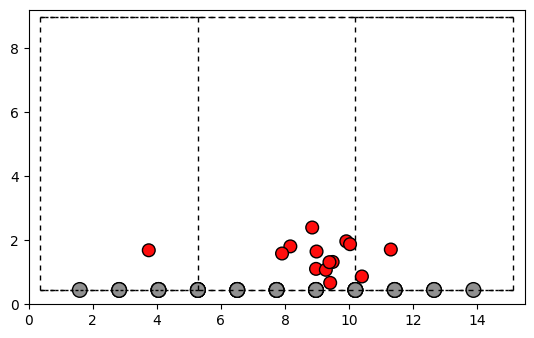

In [ ]:
from aim2dat.strct import StructureOperations

Graphene.label = "Graphene"

strct_op = StructureOperations([Graphene])
strct_op.pipeline = [[
    "add_structure_random",
    {"guest_structure": oxygen, "dist_threshold": {("C", "O"): [.8,2], ("O", "O"): [1,1.5]}},
    14
]]
strct_collect = strct_op.run_pipeline()

fig, ax = plt.subplots()
plot_atoms(strct_collect[0].to_ase_atoms(), ax, radii=0.3, rotation=('-90x,0y,0z'))